In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
(xTrain,yTrain),(xTest,yTest)=tf.keras.datasets.mnist.load_data()

In [3]:
def preprocData(dSet):
    dSetRes=dSet.reshape(dSet.shape[0],-1).T/255.0
    dSetMean=np.mean(dSetRes,axis=1).reshape(-1,1)
    return(dSetRes,dSetMean)
xTrainPreproc,trainSetMean=preprocData(xTrain)
xTrainPreproc-=trainSetMean
xTestPreproc,_=preprocData(xTest)
xTestPreproc-=trainSetMean

In [4]:
class sparseOrthoDictionaryTrainer:
    def __init__(self,trainData,spp,numIter,dictInit=None):
        if(dictInit is None):
            randSel=np.random.RandomState(2500).permutation(xTrainPreproc.shape[1])[:1001]
            dictInit,_,_=np.linalg.svd(xTrainPreproc[:,randSel])
        self.spp=spp
        self.err=np.zeros((numIter,1))
        self.trainData=trainData
        self.dict=dictInit
        self.numIter=numIter
    def spCode(self):
        proj=self.dict.T@self.trainData
        proj_s=np.sort(np.abs(proj),axis=0)[-self.spp,:]
        proj=proj*(np.abs(proj)>=proj_s)
        self.proj=proj
    def dictUpdate(self):
        mat=self.proj@self.trainData.T
        u,_,v=np.linalg.svd(mat)
        self.dict=v.T@u.T
    def fitDict(self,dispInt=0):
        print('Training')
        for i in range(self.numIter):
            self.spCode()
            self.err[i]=np.mean((self.trainData-self.dict@self.proj)**2)
            if(i%dispInt==0):
                print(f'Iteration:{i+1} Error:{self.err[i][0]:0.4f}')
            self.dictUpdate()
 
spp=50
numIter=100
mnistTrainDict=sparseOrthoDictionaryTrainer(xTrainPreproc,spp,numIter)
mnistTrainDict.fitDict(dispInt=10)

Training
Iteration:1 Error:0.0077
Iteration:11 Error:0.0058
Iteration:21 Error:0.0053
Iteration:31 Error:0.0050
Iteration:41 Error:0.0049
Iteration:51 Error:0.0048
Iteration:61 Error:0.0047
Iteration:71 Error:0.0046
Iteration:81 Error:0.0046
Iteration:91 Error:0.0045


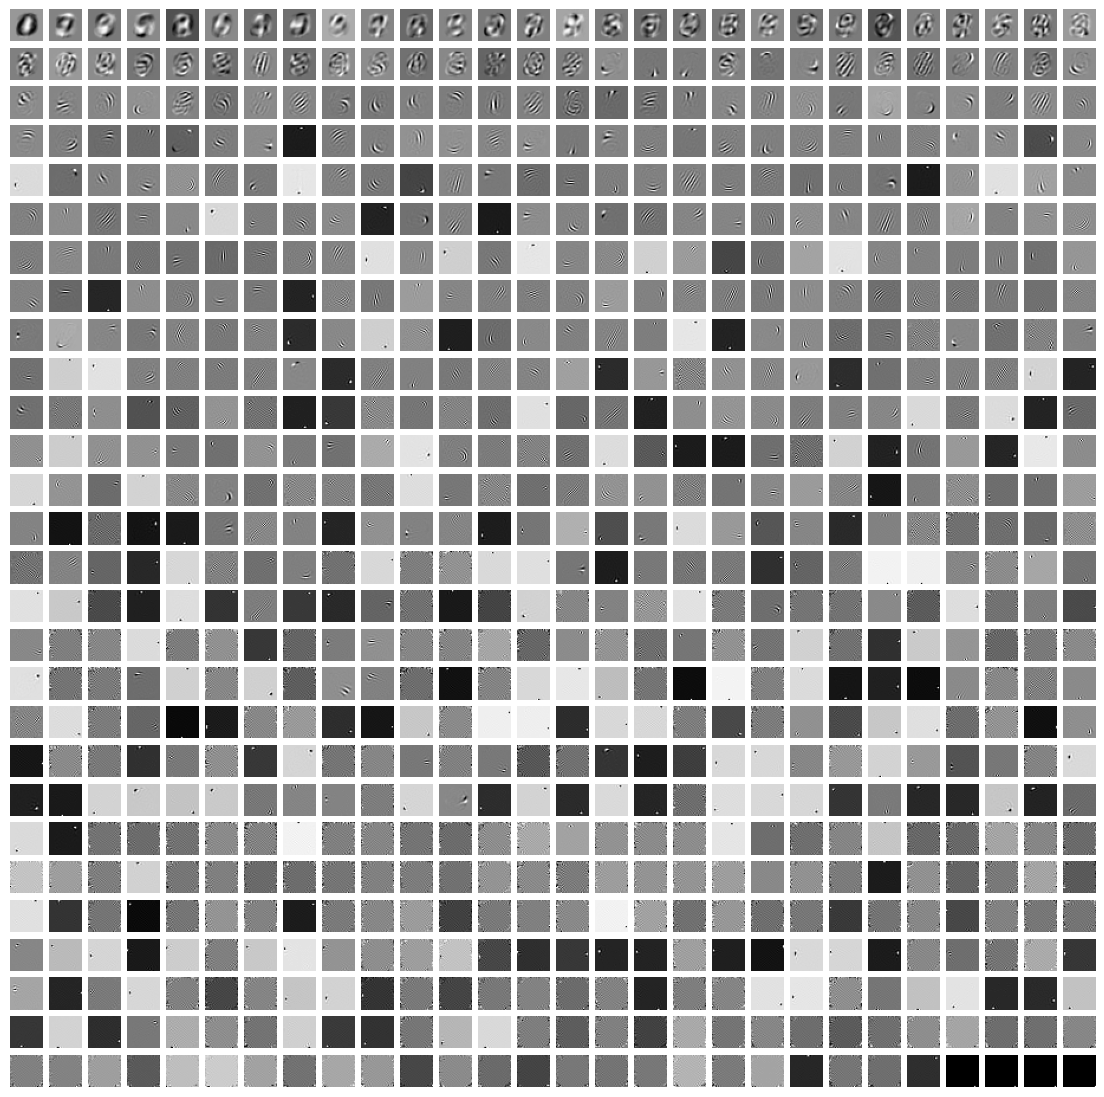

In [5]:
fig,ax=plt.subplots(nrows=28,ncols=28,figsize=(14,14))
k=0
for i in range(28):
    for j in range(28):
        ax[i,j].imshow(mnistTrainDict.dict[:,k].reshape(28,28),cmap='gray')
        ax[i,j].axis('off')
        k+=1
plt.savefig('Visualized_learned_dictionary.svg',format='svg',dpi=300)

In [18]:
recon_data=(mnistTrainDict.dict@mnistTrainDict.proj+trainSetMean)
recon_data*=recon_data>=0.0
recon_data=(recon_data/np.max(recon_data,axis=0))*255.0

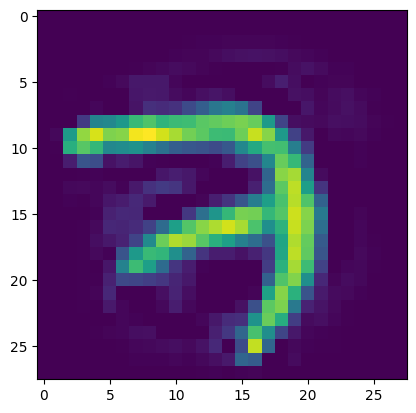

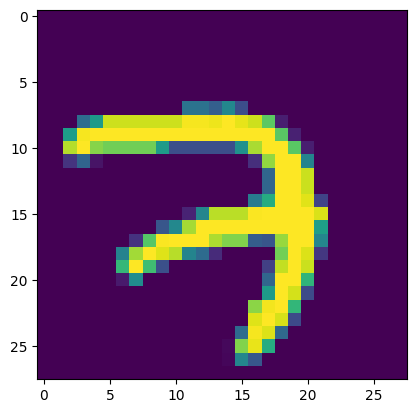

In [20]:
plt.imshow(recon_data[:,5000].reshape(28,28))
plt.figure()
plt.imshow(xTrain[5000,:,:])